# Анализ данных мошеннических транзакций

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## Подгрузка данных

In [2]:
df = pd.read_parquet('/kaggle/input/itmo-data/transaction_fraud_data.parquet')

## Общий взгляд на данные

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

## Препроцессинг

### Разложим колонку активности за последний час

In [6]:
df['last_hour_activity'][0]

{'num_transactions': 1197,
 'total_amount': 33498556.080464985,
 'unique_merchants': 105,
 'unique_countries': 12,
 'max_single_amount': 1925480.6324148502}

In [7]:
df['last_hour_activity'][1]

{'num_transactions': 509,
 'total_amount': 20114759.055250417,
 'unique_merchants': 100,
 'unique_countries': 12,
 'max_single_amount': 5149117.011434267}

In [8]:
df.head(2)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True


### Похоже, что это активность всех финансовых транзакций за последний час, а не определенного клиента

In [9]:
# df[['num_transactions_last_hour', 
#     'total_amount_last_hour',
#     'unique_merchants_last_hour', 
#     'unique_countries_last_hour',
#     'max_single_amount_last_hour']] = df['last_hour_activity'].apply(
#     lambda x: pd.Series([
#         x['num_transactions'],
#         x['total_amount'],
#         x['unique_merchants'],
#         x['unique_countries'],
#         x['max_single_amount']
#     ])
# )
activity_list = df['last_hour_activity'].tolist()

df['num_transactions_last_hour'] = [x['num_transactions'] for x in activity_list]
df['total_amount_last_hour'] = [x['total_amount'] for x in activity_list]
df['unique_merchants_last_hour'] = [x['unique_merchants'] for x in activity_list]
df['unique_countries_last_hour'] = [x['unique_countries'] for x in activity_list]
df['max_single_amount_last_hour'] = [x['max_single_amount'] for x in activity_list]

df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,num_transactions_last_hour,total_amount_last_hour,unique_merchants_last_hour,unique_countries_last_hour,max_single_amount_last_hour
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,1197,3.349856e+07,105,12,1.925481e+06
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,509,2.011476e+07,100,12,5.149117e+06
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,332,3.916385e+07,97,12,1.852242e+06
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False,764,2.201260e+07,105,12,2.055798e+06
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True,218,4.827636e+06,88,12,1.157231e+06


In [10]:
df = df.drop(columns=['last_hour_activity'])

### Приведем все транзакции в одну валюту для простоты анализа

In [11]:
df_curr = pd.read_parquet('/kaggle/input/itmo-data/historical_currency_exchange.parquet')

In [12]:
df['date'] = df['timestamp'].dt.date

In [13]:
df = df.merge(df_curr, on='date', how='left')
df['amount_usd'] = df.apply(lambda row: row.amount / row[row.currency], axis=1)
df.head(3)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,num_transactions_last_hour,total_amount_last_hour,unique_merchants_last_hour,unique_countries_last_hour,max_single_amount_last_hour,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD,amount_usd
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,False,1197,3.349856e+07,105,12,1.925481e+06,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,True,509,2.011476e+07,100,12,5.149117e+06,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,619.905757
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,False,332,3.916385e+07,97,12,1.852242e+06,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,719.506409


In [14]:
df = df.drop(df.columns[28:39], axis=1)

## Исследование данных

### Распределение суммы платежа по нормальным и мошенническим транзакциям

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Сумма транзакции относительно ее типа')

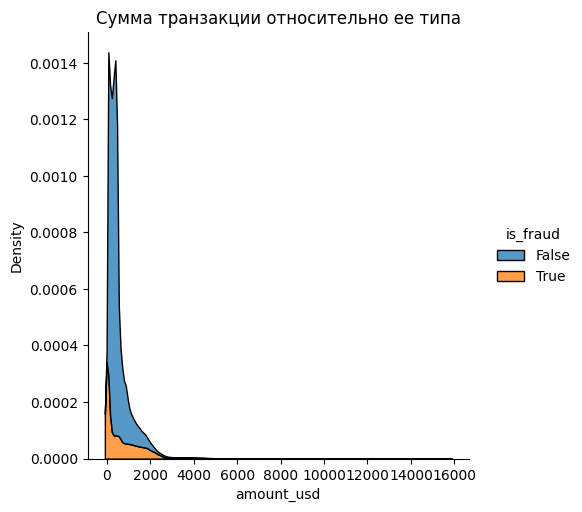

In [16]:
sns.displot(df, x="amount_usd", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Сумма транзакции относительно ее типа')

### Мошеннические транзакции не сильно отличаются от обычных по размеру платежа

### Посмотрим, как часто не совпадает валюта и страна, относительно типа транзакции

In [17]:
df['currency'].unique()

array(['GBP', 'BRL', 'JPY', 'AUD', 'NGN', 'EUR', 'MXN', 'RUB', 'CAD',
       'SGD', 'USD'], dtype=object)

In [18]:
df['country'].unique()

array(['UK', 'Brazil', 'Japan', 'Australia', 'Nigeria', 'Germany',
       'Mexico', 'Russia', 'France', 'Canada', 'Singapore', 'USA'],
      dtype=object)

In [19]:
country_currency_map = {
    'UK': 'GBP',
    'Brazil': 'BRL',
    'Japan': 'JPY',
    'Australia': 'AUD',
    'Nigeria': 'NGN',
    'Germany': 'EUR',
    'France': 'EUR',
    'Mexico': 'MXN',
    'Russia': 'RUB',
    'Canada': 'CAD',
    'Singapore': 'SGD',
    'USA': 'USD',
}

df['is_currency_matches_country'] = df['currency'] == df['country'].map(country_currency_map)

In [20]:
df['is_currency_matches_country'].value_counts()

is_currency_matches_country
True    7483766
Name: count, dtype: int64

### Валюта всегда совпадает со страной. Гипотеза о несовпадении страны и валюты (возможно мошенники) не оправдалась.

In [21]:
df = df.drop(columns=['is_currency_matches_country'])

### Посмотрим сколько в среднем транзакций имеет каждый клиент

In [22]:
df['customer_id'].value_counts()

customer_id
CUST_91730    4015
CUST_24836    3767
CUST_87928    3756
CUST_81009    3744
CUST_77434    3728
              ... 
CUST_70135    1000
CUST_81207    1000
CUST_41011    1000
CUST_65274    1000
CUST_87130    1000
Name: count, Length: 4869, dtype: int64

In [23]:
df['customer_id'].value_counts().mean()

1537.0232080509345

### У каждого клиента есть как минимум 1000 транзакций, довольно много. Возможно имеет смысл смотреть историю транзакций.

### Посмотрим количество фрода по странам

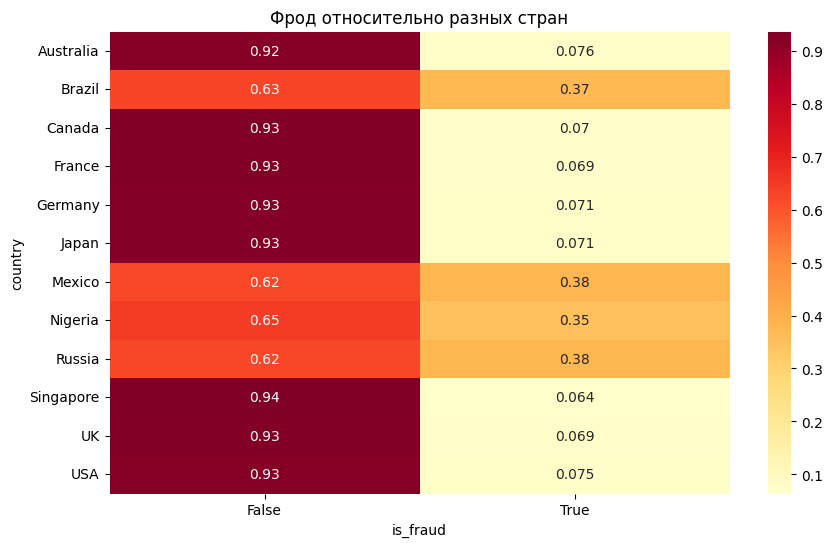

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['country'], df['is_fraud'], normalize='index'), 
            annot=True, cmap='YlOrRd')
plt.title('Фрод относительно разных стран')
plt.show()

### Бразилия, Мексика, Нигерия и Россия - выделяются среди мошеннических операций.

### Как связан фрод и последняя часовая активность

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Количество транзакций и фрод')

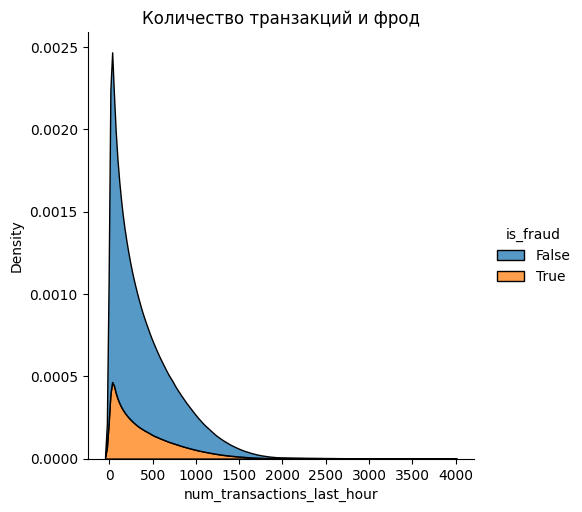

In [25]:
sns.displot(df, x="num_transactions_last_hour", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Количество транзакций и фрод')

### После 2000 транзакций в час, нормальные операции смешиваются с мошенническими.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Общая сумма транзакций и фрод')

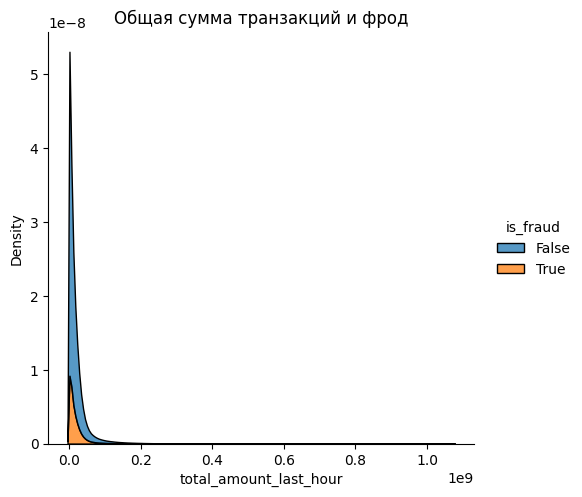

In [26]:
sns.displot(df, x="total_amount_last_hour", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Общая сумма транзакций и фрод')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Число уникальных продавцов и фрод')

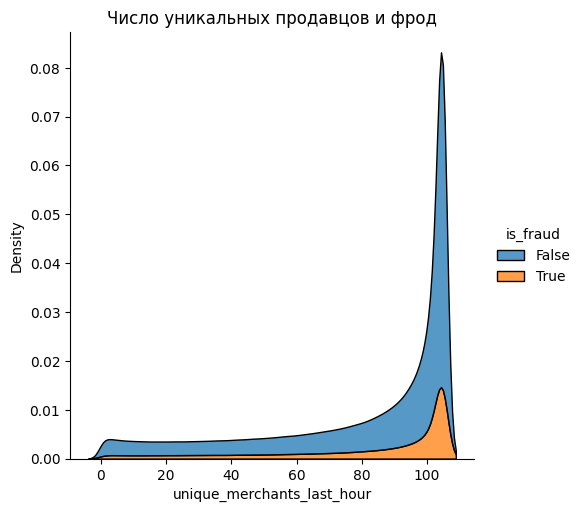

In [27]:
sns.displot(df, x="unique_merchants_last_hour", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Число уникальных продавцов и фрод')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Число уникальных стран и фрод')

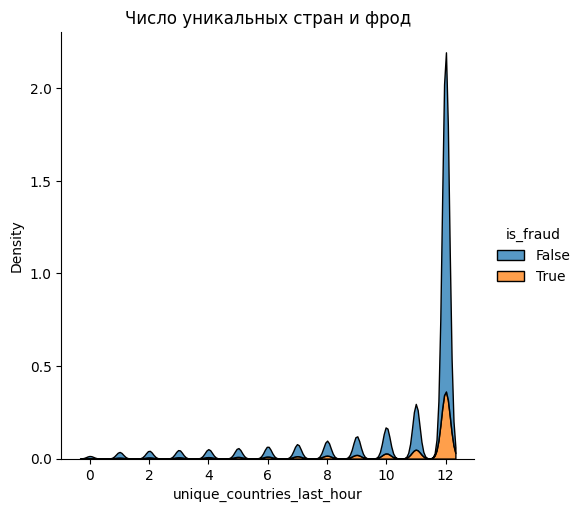

In [28]:
sns.displot(df, x="unique_countries_last_hour", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Число уникальных стран и фрод')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Максимальная сумма одной транзакции и фрод')

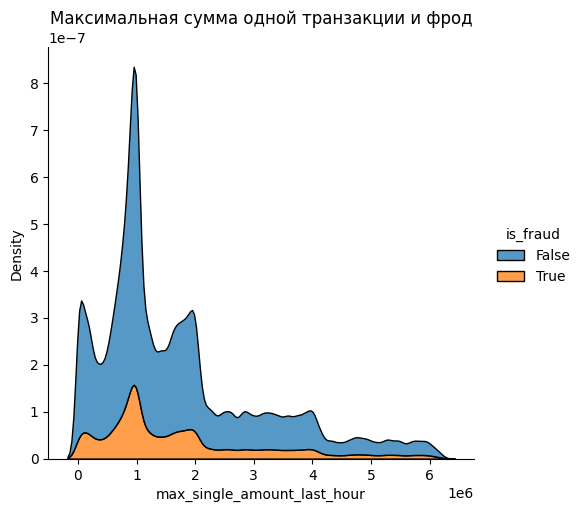

In [29]:
sns.displot(df, x="max_single_amount_last_hour", hue="is_fraud",
            kind="kde", multiple="stack")
plt.title('Максимальная сумма одной транзакции и фрод')

### Фрод довольно сильно схож с обычными транзакциями, если смотреть активность последнего часа

## Попробуем вывести новые полезные признаки

### Если много операций за последний час + страна не является домашней -> подозрительно

<Figure size 1000x600 with 0 Axes>

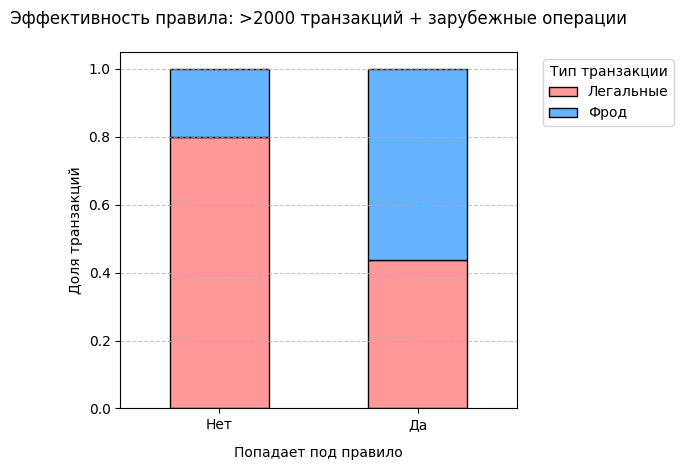

In [30]:
df['is_high_frequency_and_outside_home_country'] = (df['num_transactions_last_hour'] > 2000) & (df['is_outside_home_country'])
result = df.groupby('is_high_frequency_and_outside_home_country')['is_fraud'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
result.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff'], edgecolor='black')
plt.title('Эффективность правила: >2000 транзакций + зарубежные операции', pad=20)
plt.xlabel('Попадает под правило', labelpad=10)
plt.xticks([0, 1], ['Нет', 'Да'], rotation=0)
plt.ylabel('Доля транзакций')
plt.legend(['Легальные', 'Фрод'], title='Тип транзакции', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Похоже на сильный признак, при большом количестве операций и зарубежных операциях. Около 56% фрода ловится правилом.

### Попробуем добавить ещё одно правило: ночь + рисковый сегмент покупок

In [31]:
df['hour'] = df['timestamp'].dt.hour
df['is_night'] = (df['hour'] >= 23) | (df['hour'] < 7)
df['night_and_risky_buy'] = (df['is_high_risk_vendor']) & (df['is_night'])

df['2_rules'] = (df['night_and_risky_buy']) | (df['is_high_frequency_and_outside_home_country'])

df = df.drop(columns=['hour', 'is_night', 'night_and_risky_buy', 'is_high_frequency_and_outside_home_country'])

<Figure size 1000x600 with 0 Axes>

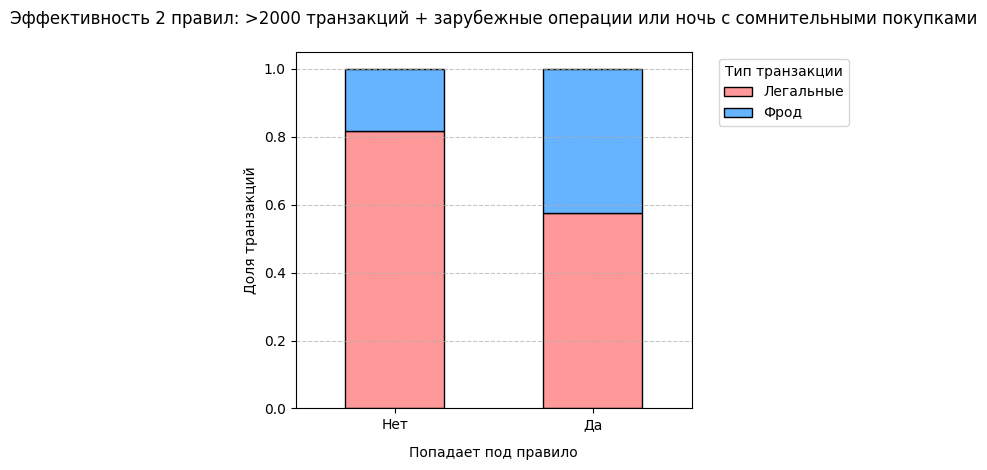

In [32]:
result = df.groupby('2_rules')['is_fraud'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
result.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff'], edgecolor='black')
plt.title('Эффективность 2 правил: >2000 транзакций + зарубежные операции или ночь с сомнительными покупками', pad=20)
plt.xlabel('Попадает под правило', labelpad=10)
plt.xticks([0, 1], ['Нет', 'Да'], rotation=0)
plt.ylabel('Доля транзакций')
plt.legend(['Легальные', 'Фрод'], title='Тип транзакции', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Стало хуже, значит новое правило не улучшает поиск фрода

### Посмотрим правило: сумма транзакции больше 3000 долларов и рисковый сегмент покупок

<Figure size 1000x600 with 0 Axes>

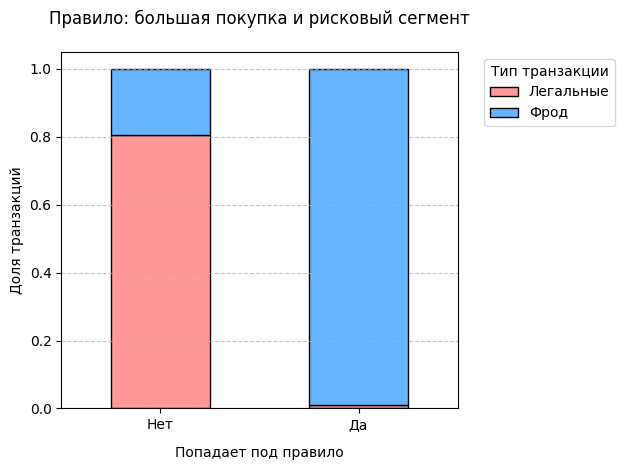

In [33]:
df['high_amount_and_risky_buy'] = (df['is_high_risk_vendor']) & (df['amount_usd'] > 3000)

result = df.groupby('high_amount_and_risky_buy')['is_fraud'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
result.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff'], edgecolor='black')
plt.title('Правило: большая покупка и рисковый сегмент', pad=20)
plt.xlabel('Попадает под правило', labelpad=10)
plt.xticks([0, 1], ['Нет', 'Да'], rotation=0)
plt.ylabel('Доля транзакций')
plt.legend(['Легальные', 'Фрод'], title='Тип транзакции', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Хороший признак, который уверенно выделяет фрод.

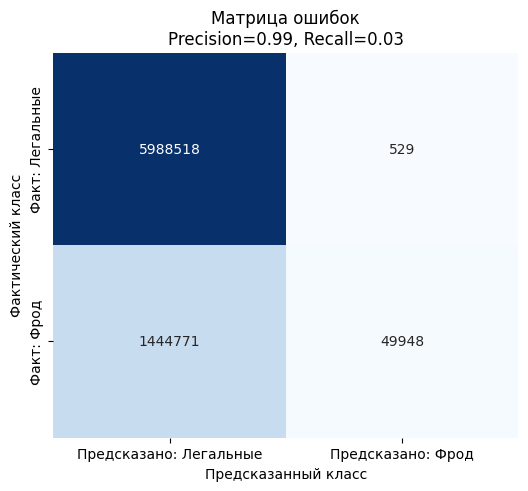

In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_true = df['is_fraud'].astype(int)
y_pred = df['high_amount_and_risky_buy'].astype(int)

cm = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Предсказано: Легальные', 'Предсказано: Фрод'],
            yticklabels=['Факт: Легальные', 'Факт: Фрод'])
plt.title(f'Матрица ошибок\nPrecision={precision:.2f}, Recall={recall:.2f}')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

### Однако выделяется очень мало фрода, не особо эффективно

### Попробуем посмотреть рискованный сегмент c крупной покупкой за рубежом

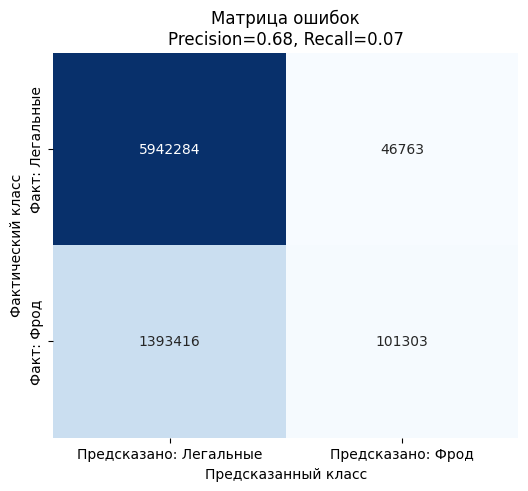

In [36]:
df['high_amount_and_risk_buy_and_not_home_country'] = (df['is_high_risk_vendor']) & (df['is_outside_home_country']) & (df['amount_usd'] > 1000)

y_true = df['is_fraud'].astype(int)
y_pred = df['high_amount_and_risk_buy_and_not_home_country'].astype(int)

cm = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Предсказано: Легальные', 'Предсказано: Фрод'],
            yticklabels=['Факт: Легальные', 'Факт: Фрод'])
plt.title(f'Матрица ошибок\nPrecision={precision:.2f}, Recall={recall:.2f}')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

### Также малое покрытие и недостаточная точность.